In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Identifying Quasars in the Sloan Digital Sky Survey

The [Sloan Digital Sky Survey](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey) was a major multi-spectral imaging survey that began in 2000, observing over 1 billion objects over ~35% of the sky.  Many (most) of these objects appear as point sources, leaving photometric (i.e., brightness) and spectroscopic (i.e., color) measurements as the only way to distinguish objects of different types.  Detailed spectra of objects can allow for robust classification, but is resource-intensive.  Gross spectral features (i.e., color) can be assessed using filters, which allow photometry over narrower bands of wavelenghs than the CCD is sensitive to.

The u, g, r, i, and z filters employed by SDSS:

<img src="https://www.sdss.org/wp-content/uploads/2014/11/camera_filters-300x274.jpg" style="width:800">

One astronomical objects SDSS proved useful in surveying is the quasar, an extremely active and luminous supermassive black hole in the center of a distant galaxy that's undergoing accretion.  As point sources, they are non-trivial to distinguish from other point sources in the survey, namely stars and white dwarfs in the Milky Way.  Confident classification can, and has, been done from spectral observations.  We'll use these confident spectroscopic classifications to train a logistic regression model to predict source classes based on the basic color information provided by SDSS's u, g, r, i, and z filters.

# Data

The data we'll be using is spread across three separate files, separated by spectroscopically confirmed classifications.

### Stars
First we'll pull data from spectroscopically confirmed stars:
```bash
!wget -q --no-check-certificate -O ../data/SDSS_stars.csv https://astrostatistics.psu.edu/MSMA/datasets/SDSS_stars.csv
```


This is a pretty standard csv file, which we can read in the usual way.

In [2]:
stars = pd.read_csv('../data/SDSS_stars.csv')
stars.head()

,u_mag,g_mag,r_mag,i_mag,z_mag,ra,dec
0,20.533161,17.968031,16.827314,16.373095,16.091063,190.001261,21.910620
1,18.894476,17.674576,17.208895,17.033516,16.972940,190.002330,21.874641
2,18.290901,17.022612,16.625498,16.431305,16.399673,190.012240,21.702999
3,19.784182,17.820679,17.003235,16.721306,16.541569,190.012912,23.667913
4,18.874607,17.638632,17.120625,16.907972,16.849592,190.012951,24.797507


We see magnitudes (recall, a logarithmic measure of brightness where larger means fainter;  thanks Hipparchus!) across the 5 filters employed by SDSS, as well as coordinates on the sky. Lets create a list of the names of the photometric measurements we'll be using for future use.

In [3]:
bands = ['u_mag', 'g_mag', 'r_mag', 'i_mag', 'z_mag']

### White dwarfs

White dwarfs are also in a CSV
```bash
!wget -q --no-check-certificate -O ../data/SDSS_wd.csv https://astrostatistics.psu.edu/MSMA/datasets/SDSS_wd.csv
```

Annoyingly there's a bunch of white space around the column names that pandas keeps.  The easiest way to get rid of this when reading in the file is to use a [regular](https://en.wikipedia.org/wiki/Regular_expression) [expression](https://regex101.com/r/AsD9jR/2) to specify a delimiter that's a comma surrounded by an abitrary amount of white space.

In [4]:
wds = pd.read_csv('../data/SDSS_wd.csv', sep="\s*[,]\s*", engine='python')
wds.head()

,Sp_Class,u_mag,g_mag,r_mag,i_mag,z_mag,RA,Dec
0,DA_auto,19.186,18.835,18.884,19.052,19.407,0.028147,-0.781616
1,DA,19.421,19.565,20.000,20.277,21.152,0.029836,-9.727753
2,DQ,19.413,19.091,19.052,19.120,19.339,0.048182,-8.835651
3,DA_auto,20.423,20.041,19.925,20.030,20.012,0.051346,-0.845157
4,DA,19.285,18.891,18.810,18.886,18.958,0.093902,-10.861710


Here we see the same photometric measurements, sky coordinates, as well as classification informations that we won't be needing.

### Quasars

Finally let's pull the spectroscopically confirmed Quasars.  More information on the data set can be found [here](https://astrostatistics.psu.edu/datasets/SDSS_quasar.html).
```bash
!wget -q --no-check-certificate -O ../data/SDSS_quasar.dat https://astrostatistics.psu.edu/datasets/SDSS_quasar.dat
```

In [5]:
!head -n3 ../data/SDSS_quasar.dat

SDSS_J              R.A.        Dec.          z     u_mag   sig_u   g_mag   sig_g   r_mag   sig_r   i_mag   sig_i   z_mag   sig_z   Radio   X-ray   J_mag   sig_J   H_mag   sig_H   K_mag   sig_K   M_i
000009.26+151754.5  0.038605    15.298476   1.1986  19.921  0.042   19.811  0.036   19.386  0.017   19.165  0.023   19.323  0.069   -1.000  -9.000  0.000   0.000   0.000   0.000   0.000   0.000   -25.085
000009.38+135618.4  0.039088    13.938447   2.2400  19.218  0.026   18.893  0.022   18.445  0.018   18.331  0.024   18.110  0.033   -1.000  -9.000  0.000   0.000   0.000   0.000   0.000   0.000   -27.419


We see that it's not comma-delimited, but instead what's called fixed-width. We can use `pd.read_fwf()` to handle this.

In [6]:
qsos = pd.read_fwf('../data/SDSS_quasar.dat')
qsos.head()

,SDSS_J,R.A.,Dec.,z,u_mag,sig_u,g_mag,sig_g,r_mag,sig_r,...,sig_z,Radio,X-ray,J_mag,sig_J,H_mag,sig_H,K_mag,sig_K,M_i
0,000009.26+151754.5,0.038605,15.298476,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,...,0.069,-1.0,-9.00,0.000,0.000,0.00,0.000,0.000,0.000,-25.085
1,000009.38+135618.4,0.039088,13.938447,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,...,0.033,-1.0,-9.00,0.000,0.000,0.00,0.000,0.000,0.000,-27.419
2,000009.42-102751.9,0.039269,-10.464428,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,...,0.047,0.0,-9.00,0.000,0.000,0.00,0.000,0.000,0.000,-26.459
3,000011.41+145545.6,0.047547,14.929353,0.4596,19.637,0.030,19.466,0.024,19.362,0.022,...,0.047,-1.0,-9.00,0.000,0.000,0.00,0.000,0.000,0.000,-22.728
4,000011.96+000225.3,0.049842,0.040372,0.4790,18.237,0.028,17.971,0.020,18.025,0.019,...,0.029,0.0,-1.66,16.651,0.136,15.82,0.149,14.821,0.111,-24.046


Here we have lots more info, including catalog IDs, uncertaines on photometric measurements, etc.

## Prepare Training Set

Now we'll prepare our training set.  The first thing we'll note is the number of each class of object we have.

In [7]:
len(stars), len(wds), len(qsos)

(5000, 10090, 46420)

It looks like the smallest set is the collection of stars.  To make our training set more uniform we'll select a subsets of the other objects to have an equal number of every class.

One thing that will cause trouble later if we don't deal with now is the presence of NaNs (not-a-number's).  The white dwarf data set contains some missing data.

In [8]:
wds.isna().any()

Sp_Class    False
u_mag        True
g_mag        True
r_mag        True
i_mag        True
z_mag        True
RA          False
Dec         False
dtype: bool

So when we select our subset of 5000 white dwards we'll make sure to avoid them.  Since we have white dwarfs to spare, lets also focus on the bright ones, to reduce the effects of potentially noisy observations of faint objects.  We'll do that by selecting only objects with a magnitude brighter (i.e., less) than 21 across all filters.

In [9]:
wd_sel = ~(np.any(wds[bands] > 21.0, axis=1) | np.any(np.isnan(wds[bands]), axis=1))
print(np.count_nonzero(wd_sel))

9260


With plenty left, we'll select 5000 random white dwarfs.

In [10]:
N = 5000
wds = wds[wd_sel].sample(N)
wds

,Sp_Class,u_mag,g_mag,r_mag,i_mag,z_mag,RA,Dec
9395,DA_auto,18.657,18.613,18.958,19.271,19.525,318.172984,-0.692754
260,DZ,19.805,19.443,19.445,19.425,19.569,10.348269,15.185827
6650,DB,19.694,19.738,19.967,20.195,20.304,205.336981,0.701320
7422,DA_auto,17.444,17.207,17.472,17.735,17.981,221.681422,52.131447
5911,DA,19.579,19.931,20.392,20.661,20.579,185.729195,0.679705
...,...,...,...,...,...,...,...,...
1068,DA,19.491,19.049,19.251,19.444,19.820,46.903313,1.184577
6086,DA_auto,20.951,20.401,20.324,20.404,20.579,190.430729,63.252562
1512,DA_auto,20.538,19.963,20.126,20.221,20.490,114.625509,32.621430
8315,DC,19.423,19.171,19.117,19.225,19.369,238.760586,55.063609


Let's take the same approach to selecting a subset of quasars (it turns out there aren't any NaNs here).

In [11]:
qso_sel = ~np.any(qsos[bands] > 21.0, axis=1)
print(np.count_nonzero(qso_sel))

41983


In [12]:
qsos = qsos[qso_sel].sample(N)
qsos

,SDSS_J,R.A.,Dec.,z,u_mag,sig_u,g_mag,sig_g,r_mag,sig_r,...,sig_z,Radio,X-ray,J_mag,sig_J,H_mag,sig_H,K_mag,sig_K,M_i
17211,101025.01+003402.5,152.6042,0.567365,1.6370,19.610,0.035,19.438,0.017,19.511,0.021,...,0.072,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.701
28239,130129.44+023848.5,195.3727,2.646829,1.8606,19.551,0.035,19.267,0.021,19.195,0.018,...,0.055,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-26.333
45336,230250.85+143203.2,345.7119,14.534223,0.6541,20.123,0.045,19.547,0.018,19.428,0.019,...,0.064,-1.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-23.701
17188,101006.20+035712.8,152.5258,3.953557,1.6610,18.303,0.019,18.210,0.020,18.172,0.017,...,0.027,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-27.074
19796,104529.74+013350.6,161.3739,1.564066,0.6890,17.957,0.020,17.544,0.022,17.524,0.013,...,0.024,0.000,-9.000,16.251,0.100,15.913,0.153,15.217,0.184,-25.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30347,133811.47+635415.7,204.5477,63.904362,1.3274,19.169,0.028,19.114,0.018,18.840,0.022,...,0.051,14.066,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-25.578
17618,101557.31+614715.1,153.9888,61.787541,0.4752,19.295,0.029,19.021,0.023,19.028,0.017,...,0.049,0.000,-1.267,17.218,0.210,16.535,0.265,15.623,0.163,-23.087
8804,083914.14+485125.7,129.8089,48.857165,2.9560,20.888,0.073,18.979,0.018,18.605,0.017,...,0.035,0.000,-9.000,16.952,0.196,16.661,0.263,15.769,0.238,-27.785
25804,122032.94+572401.8,185.1372,57.400500,0.3121,19.698,0.037,19.052,0.048,18.693,0.013,...,0.028,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,-22.217


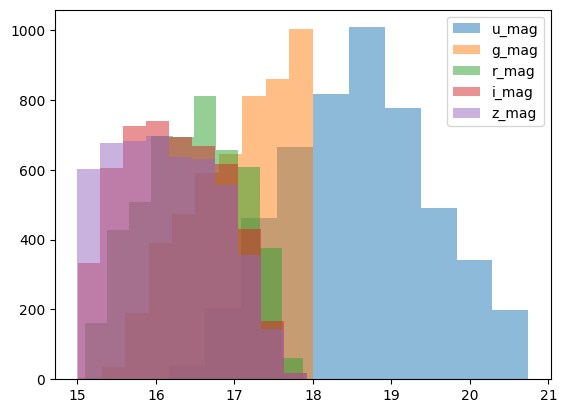

In [13]:
for band in bands:
    plt.hist(stars[band], label=band, alpha=0.5);
plt.legend();

It's important to remember, though, that these data live in a 5-D feature space.  We have the measured magnitude across 5 bands _for each object_.  We can get a better sense of the relationships between observed variables by looking at a pair, or corner, plot.

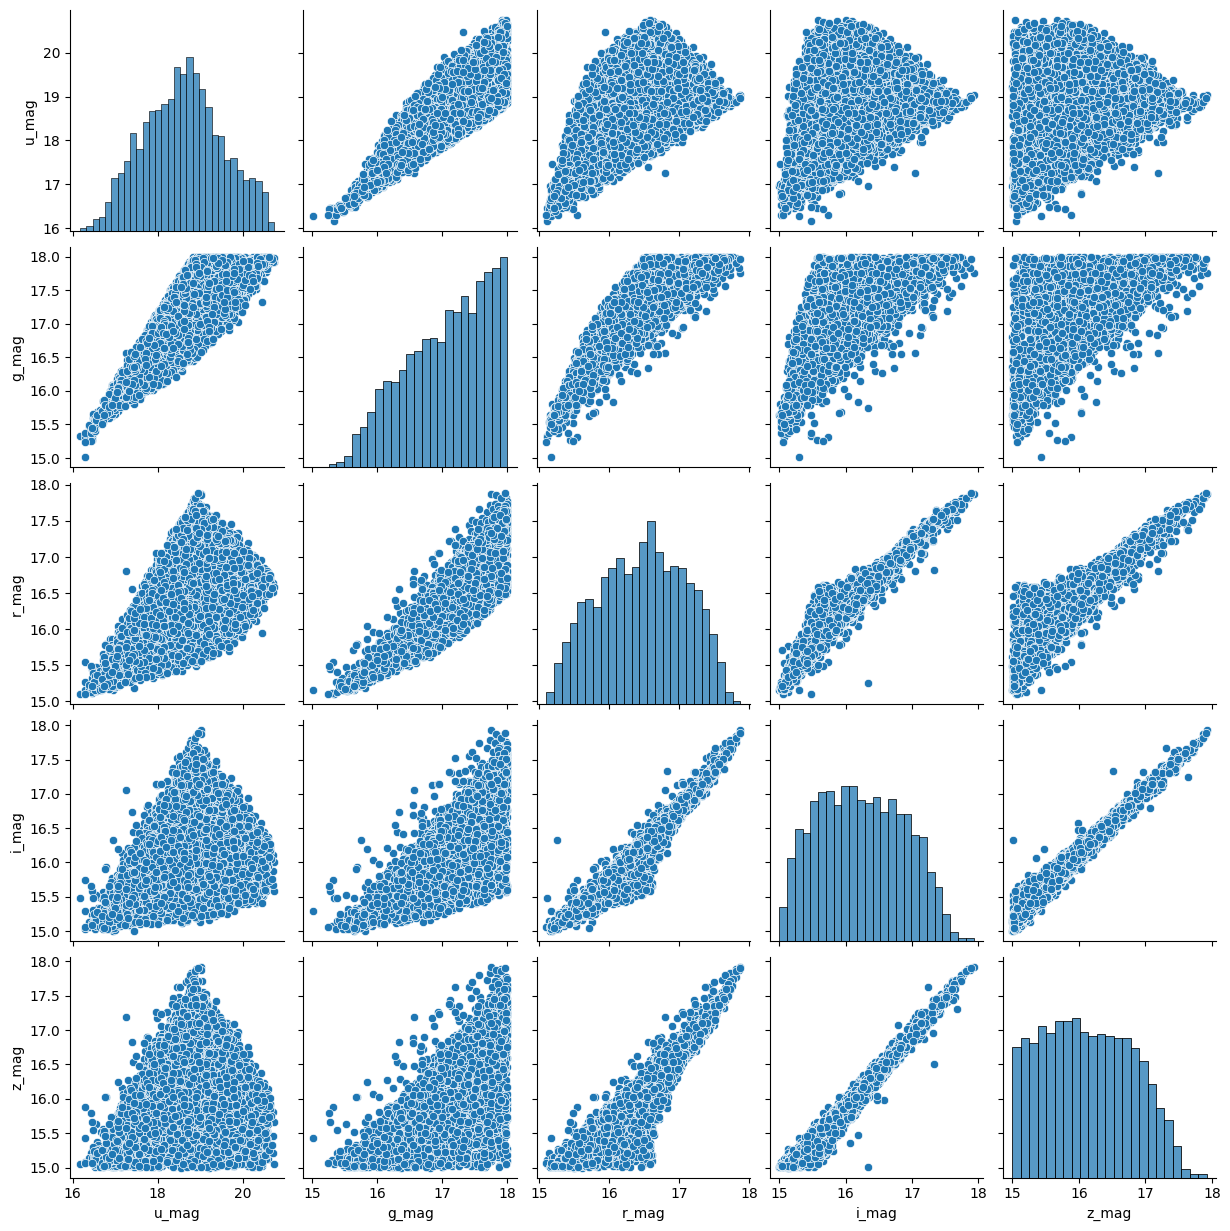

In [14]:
sns.pairplot(stars, vars=bands);

This figure shows scatter plots in the labeled pairs of dimensions in the off-diagonal spaces, and 1-D histograms of each variable along the diagonal.  Notice many of these magnitudes have strong linear correlations; this is due to a common (but unknown) factor between them: the distance to the source.  Since we won't want to rely on _knowing_ the distance to a source (necessary to determine the intrinsic, or absolute, brightness of the object) we can remove it's effects by taking the differences in magnitudes in different filters (remember they're logarithmic quantities!) to have quantitative measures of color.

We'll work with four color quantities.

In [15]:
colors = ['u-g', 'g-r', 'r-i', 'i-z']

We'll cycle through the dataframes we have and add columns containing these color quantities.

In [16]:
for cs in colors:
    c1, c2 = cs.split('-')
    for df in [stars, wds, qsos]:
        df[cs] = df['{}_mag'.format(c1)].copy() - df['{}_mag'.format(c2)].copy()

Let's how the data look in color space.

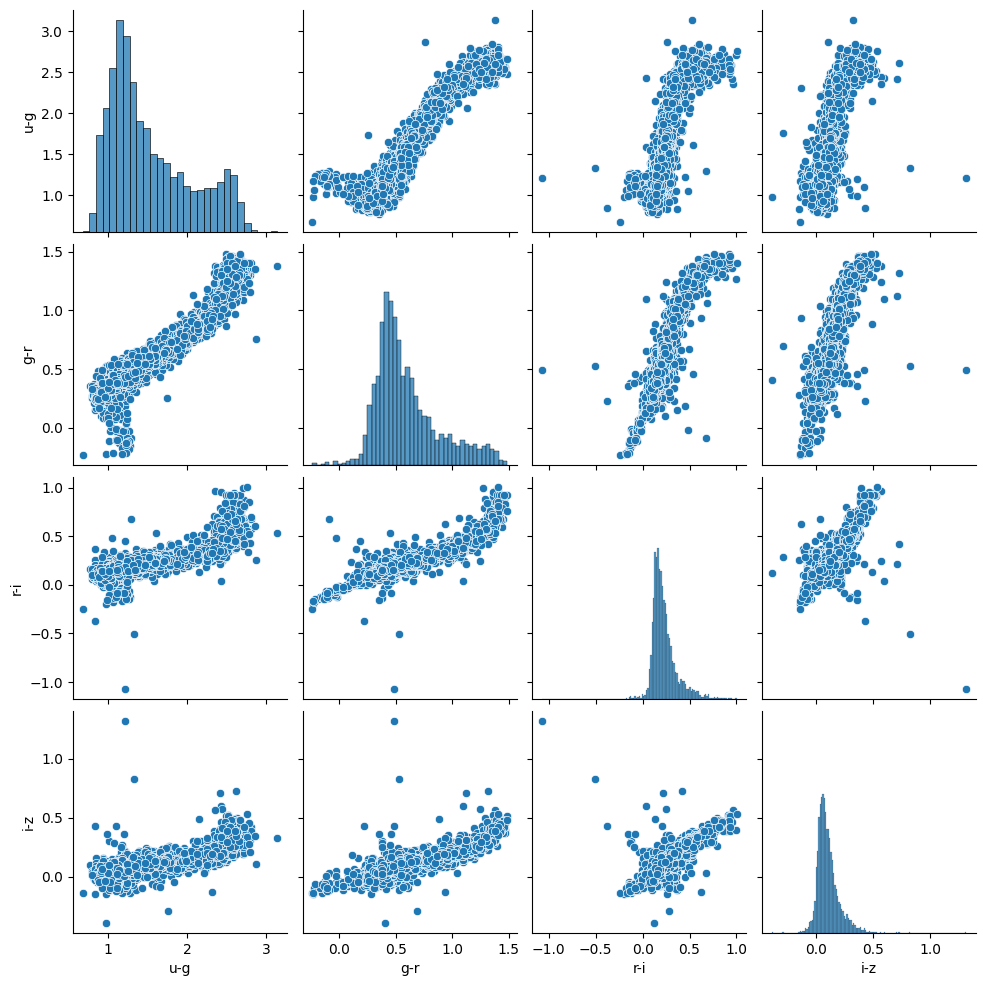

In [17]:
sns.pairplot(stars, vars=colors);

Much more interesting!

Finally, lets add a column to each dataframe containing object classes, concatenate the frames (only keeping the color quantities and classification), shuffle it, and write it to file.

In [18]:
stars['class'] = 'star'
wds['class'] = 'wd'
qsos['class'] = 'qso'

In [19]:
training = pd.concat([df[colors+['class']] for df in [stars, wds, qsos]])

Let's separate a random 10% of the data for testing, then save these data to file.

In [22]:
training = training.sample(frac=1).reset_index(drop=True)   # shuffles and resets the counting index
testing = training.sample(frac=0.2)                         # takes 20% of the data for testing
training = training.drop(testing.index)                     # drops the testing data from the training data

training.to_csv('SDSS_training.csv', index=False)  # write to file
testing.to_csv('SDSS_testing.csv', index=False)    # write to file

# Quasar classifier

Now let's finally get to building and training a quasar classifier.  For this we'll use a logististic regression model to isolate quasars.

To make use of the functions we've already written, lets pack our features into a design matrix and turn the labels into a $\{0, 1\}$ column vector.  Let's start simple and focus on $u-g$ and $g-r$ first.

In [24]:
training = pd.read_csv('SDSS_training.csv')  # not necessary if you just ran the cells above
testing = pd.read_csv('SDSS_testing.csv')    # not necessary if you just ran the cells above

In [25]:
stars = training['class'] == 'star'
wd = training['class'] == 'wd'
qsos = training['class'] == 'qso'

stars_test = testing['class'] == 'star'
wd_test = testing['class'] == 'wd'
qsos_test = testing['class'] == 'qso'

In [26]:
X = np.column_stack([np.ones(len(training)),
                     training[['u-g', 'g-r']]])
X_test = np.column_stack([np.ones(len(testing)),
                          testing[['u-g', 'g-r']]])

y = np.array(training['class'] == 'qso')
y_test = np.array(testing['class'] == 'qso')
y = y.reshape(-1, 1).astype('int')
y_test = y_test.reshape(-1, 1).astype('int')
y

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Now for the functions we previously wrote.

In [27]:
from scipy.special import expit
from scipy.optimize import minimize

def cost(theta, X=X, y=y):
    m = y.size
    h = expit(X.dot(theta))

    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
    J = J[0]

    if np.isnan(J):
        return np.inf

    return J

def cost_gradient(theta, X=X, y=y):
    m = y.size
    h = expit(X.dot(theta.reshape(-1, 1)))

    gradient = 1/m * X.T.dot(h - y)

    return gradient.flatten()

We'll once again use `scipy`'s `minimize()` function to minimize the cost function.

In [28]:
theta0 = np.random.randn(X.shape[1]) # random starting weights

c = cost(theta0, X, y)
c_grad = cost_gradient(theta0, X, y)
print('starting theta: \n', theta0)
print('Cost: \n', c)
print('Grad: \n', c_grad)

starting theta: 
 [-0.40018683 -0.49903877 -0.89782475]
Cost: 
 0.6017089356908805
Grad: 
 [-0.03216466  0.04253114 -0.03590886]


In [29]:
res = minimize(cost, theta0, method=None, jac=cost_gradient, options={'maxiter':400})

theta_opt = res.x.reshape((-1, 1))

res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3281687172689691
        x: [ 1.726e+00 -7.244e+00  1.003e+01]
      nit: 20
      jac: [ 6.013e-06  2.440e-07  1.400e-06]
 hess_inv: [[ 2.578e+01 -5.211e+01  6.529e+01]
            [-5.211e+01  1.738e+02 -2.445e+02]
            [ 6.529e+01 -2.445e+02  4.608e+02]]
     nfev: 22
     njev: 22

Now we can use our trained model to assess our training accuracy, i.e., what percentage of the training set our model correctly categorizes.

In [30]:
def h(X, theta=theta_opt):
    return expit(X.dot(theta))

def predict(X, theta=theta_opt, threshold=0.5):
    p = h(X, theta) >= threshold
    return p.astype('int')

p = predict(X)
p_test = predict(X_test)

accuracy = 100 * np.count_nonzero(p == y)/p.size
accuracy_test = 100 * np.count_nonzero(p_test == y_test)/p_test.size
print("training accuracy: {:.1f}%".format(accuracy))
print("testing accuracy: {:.1f}%".format(accuracy_test))

training accuracy: 88.9%
testing accuracy: 87.9%


To get a sense of what our model learned, lets evaluate our hypothesis across a 2-D grid in $u-g$, $g-r$ color space and draw the $h_\theta(X)==0.5$ contour, i.e., our decision boundary.

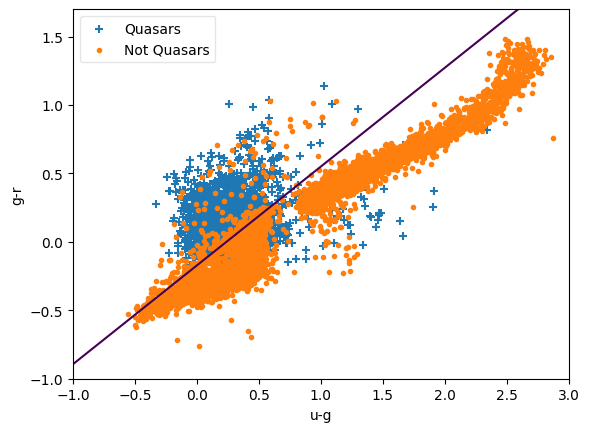

In [31]:
xlabel='u-g'
ylabel='g-r'

plt.scatter(X[qsos][:, 1], X[qsos][:, 2], marker='+', label="Quasars")
plt.scatter(X[~qsos][:, 1], X[~qsos][:, 2], marker='.', label="Not Quasars")

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(-1, 3)
plt.ylim(-1, 1.7)
plt.legend()

x1low, x1high = plt.xlim()
x2low, x2high = plt.ylim()
xx1, xx2 = np.meshgrid(np.linspace(x1low, x1high, 100), np.linspace(x2low, x2high, 100))

testX = np.column_stack([np.ones(xx1.size), xx1.ravel(), xx2.ravel()])
hh = h(testX).reshape(xx1.shape)

plt.contour(xx1, xx2, hh, [0.5])
plt.legend(framealpha=0.5);

Looking at this it's clear that our linear decision boundary in this space doesn't have much room left for improvement; the populations overlap pretty substantially.

Let's try leveraging the full 5-D feature space we prepared.  All of the functions we've written will work out of the box, but the 2-D visualization above will no longer be useful.

First let's look at how the classes fall in our 5-D space.

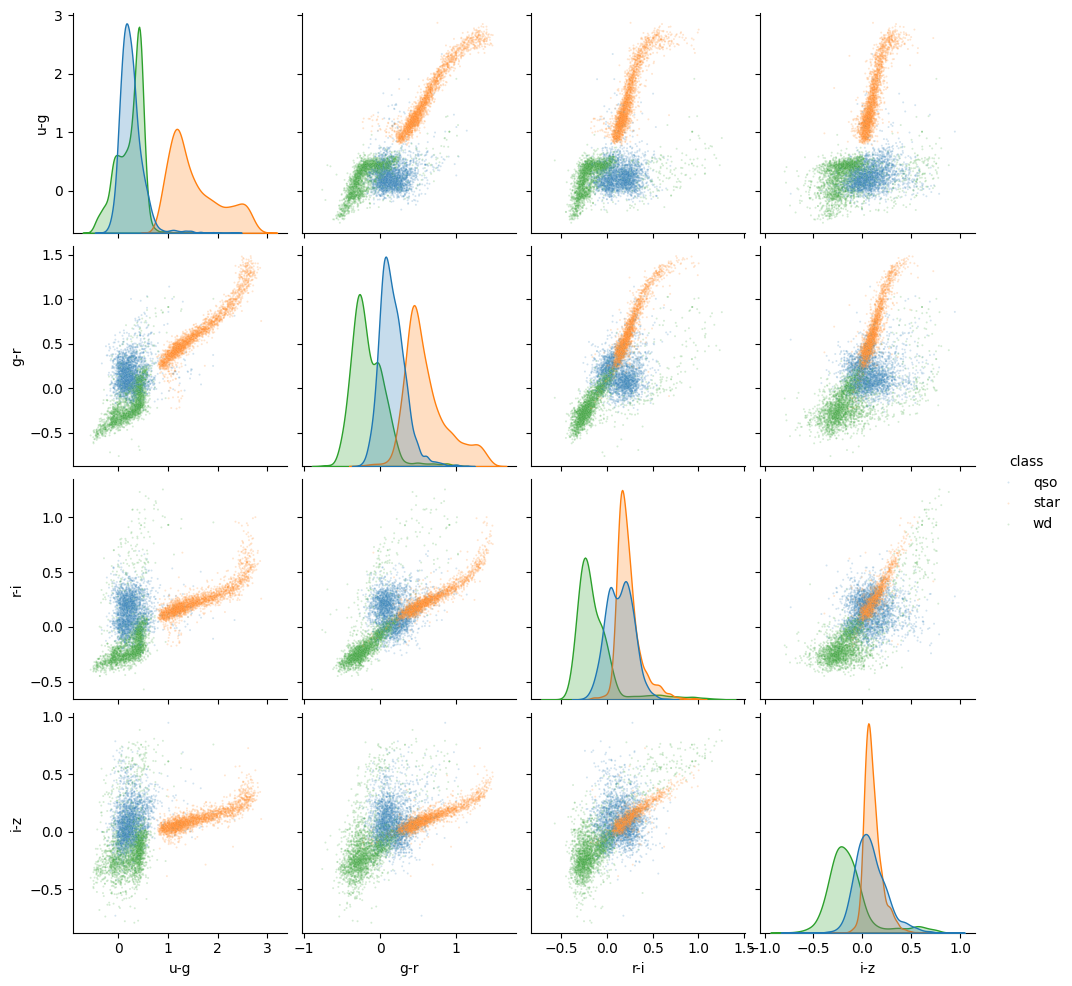

In [32]:
sns.pairplot(training, hue='class', plot_kws={'s':2, 'alpha':0.2});

Now let's update our design matrix and retrain.

In [33]:
X = np.column_stack([np.ones(len(training)),
                     training[colors]])
X_test = np.column_stack([np.ones(len(testing)),
                          testing[colors]])

In [34]:
theta0 = np.random.randn(X.shape[1]) # random starting weights

res = minimize(cost, theta0,
               args=(X, y),              # pass in the new design matrix
               method=None,
               jac=cost_gradient,
               options={'maxiter':400})

theta_opt = res.x.reshape((-1, 1))

res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.30024170620690815
        x: [ 1.587e+00 -6.643e+00  6.832e+00  2.650e+00  2.906e+00]
      nit: 43
      jac: [ 2.380e-06 -1.939e-07  1.994e-06 -5.757e-07  3.282e-06]
 hess_inv: [[ 2.442e+01 -4.155e+01 ... -7.857e+00  1.386e+01]
            [-4.155e+01  1.219e+02 ...  1.958e+01 -1.611e+01]
            ...
            [-7.857e+00  1.958e+01 ...  4.995e+02 -1.847e+02]
            [ 1.386e+01 -1.611e+01 ... -1.847e+02  4.095e+02]]
     nfev: 44
     njev: 44

In [35]:
p = predict(X, theta=theta_opt)
p_test = predict(X_test, theta=theta_opt)

accuracy = 100 * np.count_nonzero(p == y)/p.size
accuracy_test = 100 * np.count_nonzero(p_test == y_test)/p_test.size
print("training accuracy: {:.1f}%".format(accuracy))
print("testing accuracy: {:.1f}%".format(accuracy_test))

training accuracy: 92.1%
testing accuracy: 90.0%


Better... To get a sense of how our model could improve, let's look at where the mis-identified objects fall in our feature space.

In [36]:
correct = (p==y).flatten()
correct_test = (p_test==y_test).flatten()

Let's first look at the original colors we trained on.

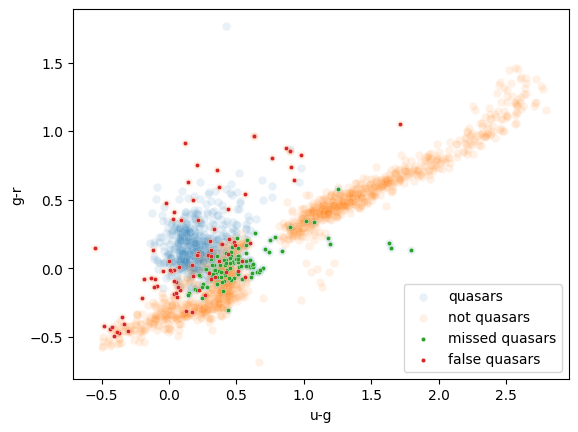

In [37]:
sns.scatterplot(x='u-g', y='g-r', data=testing[qsos_test], label='quasars', alpha=0.1)
sns.scatterplot(x='u-g', y='g-r', data=testing[~qsos_test], label='not quasars', alpha=0.1)
sns.scatterplot(x='u-g', y='g-r', data=testing[~correct_test & qsos_test], label='missed quasars', s=10)
sns.scatterplot(x='u-g', y='g-r', data=testing[~correct_test & ~qsos_test], label='false quasars', s=10);

Instead of plotting lots of points, we can also plot the training distribution as contours using KDEs.

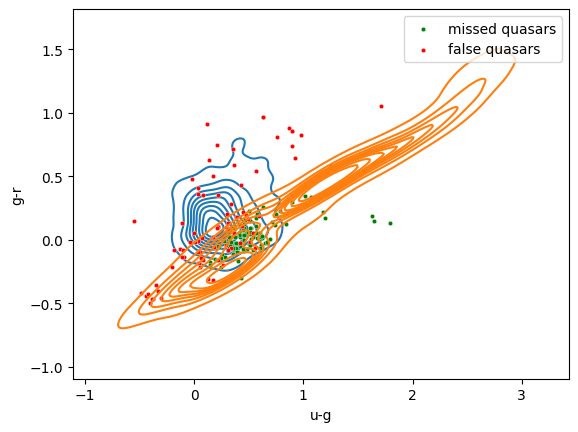

In [38]:
sns.kdeplot(x='u-g', y='g-r', data=training[qsos], label='quasars', zorder=1,)
sns.kdeplot(x='u-g', y='g-r', data=training[~qsos], label='not quasars')
sns.scatterplot(x='u-g', y='g-r', data=testing[~correct_test & qsos_test], label='missed quasars', s=10, color='g')
sns.scatterplot(x='u-g', y='g-r', data=testing[~correct_test & ~qsos_test], label='false quasars', s=10, color='r');

Now let's do it with a full pairplot (WARNING: this takes a while).

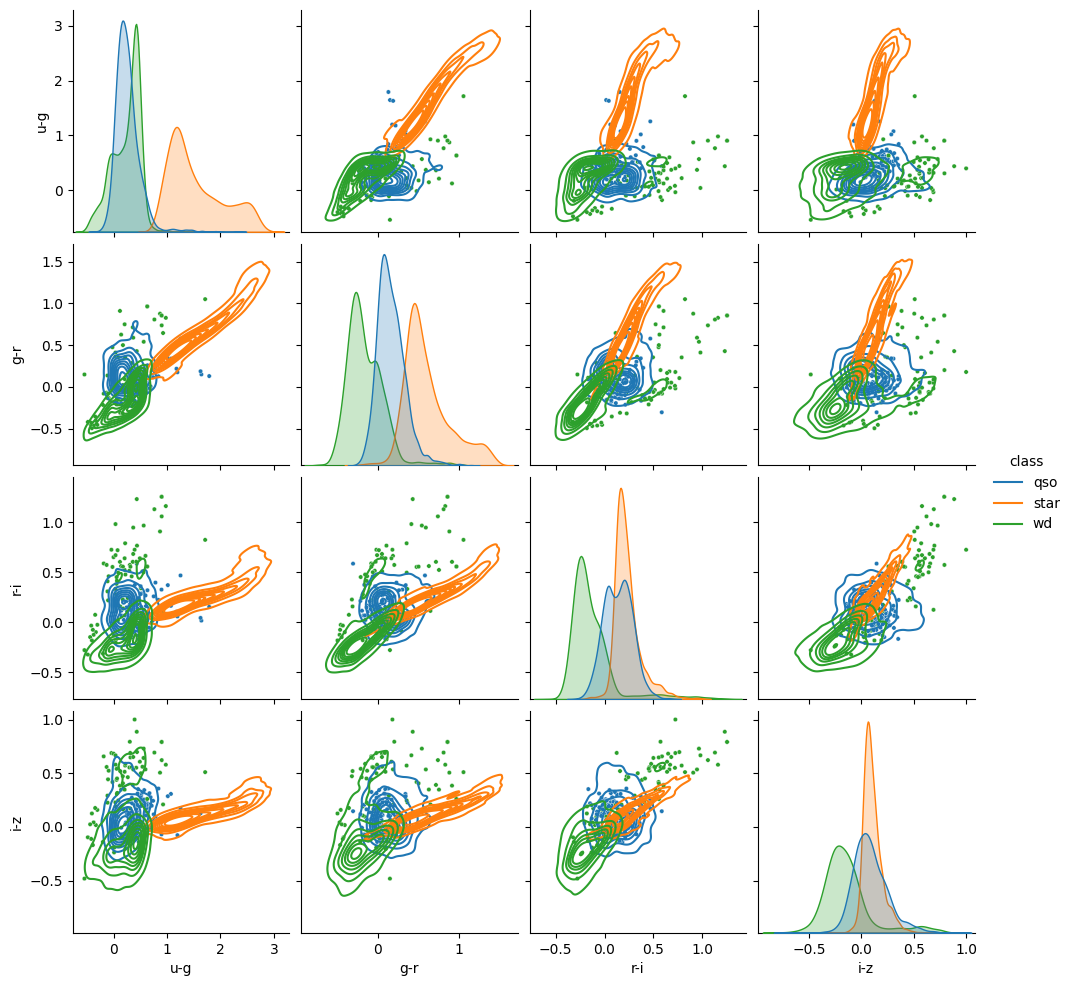

In [39]:
g = sns.pairplot(training, hue='class', kind='kde')
for ax in g.axes.flatten():
    try:
        xlabel, ylabel = ax.get_xlabel(), ax.get_ylabel()
        sns.scatterplot(x=xlabel, y=ylabel, data=testing[~correct_test],
                        hue='class', hue_order=g.hue_names, s=10,
                        legend=False, ax=ax)
    except:
        pass

So it looks like we're having difficulty separating white dwarfs from quasars.  It's fairly easy to separate stars from quasars in this color space.

In [40]:
np.count_nonzero(training[~correct]['class'] == 'star')

0